# Pulsed NMR Individual Analysis

In [18]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
# import uncertainties as unc
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Prior to working on this notebook:

1. Obtain the measurements of $T_1$ and $T_2$ half-life times for the series of measurements taken from Experiment 2, the effects of paramagnetic ions on the decay constants.  The data are ordered in terms of dilution "number".

2. Obtain the measurements of the delay times versus echo amplitudes from Experiment 3.  The data should be in a simple .csv spreadsheet.

### Then...
3. Import the data tables for each experiment.

### For Experiment 2:

4. Convert the "dilution number" to ion concentration in moles/liter ("molarity").  See below for details.

5. Convert the half-life times to $T_1$, $T_2$ values.

6. Plot $T_1$, and $T_2$ versus concentration on the same graph.  Select axis types (linear or log) to make the relationship look like a line.  

7. in your group document, compare your graph to the results reported by Hahn.

### For Experiment 3:

8. Convert the delay times to echo-position times.  (What is the relationship between the time of the B pulse and the echo produced by it?)

9. Plot the echo amplitudes versus echo times.

10. Fit the data set to the function given in the instructions on page 25 and 26 to obtain the constant $K$.  For $T_2$ use the result for water, and fix it so that it does not get adjusted by the fitting routine.



## Import data tables

Display them so that you know they are correct.

In [19]:
# Read in the data to a Pandas dataframe and print a table.
echo_data = pd.read_csv('echo.csv')
echo_data

,delay,echo
0,6,4.40
1,9,4.24
2,11,4.14
3,14,3.74
4,17,3.36
5,20,2.78
6,23,2.20
7,26,1.99
8,29,1.55
9,32,1.11


## Experiment 3: diffusion study

### Massage the collected data

Rescale the **Delay_time** data to give the echo-position time.

In [20]:
#the echo-position time is twice the delay time because the larmor precession is symmetric before and after the pi pulse
echo_position = echo_data['delay']*2/1000
echo_amp = echo_data['echo']

### Plot it

Plot the echo peak voltage vs. echo-position time.

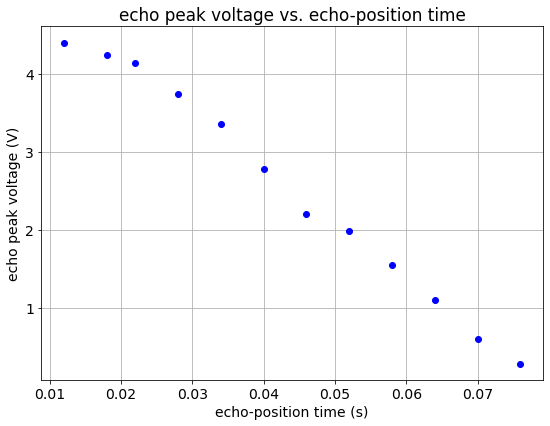

In [21]:
# plot default
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

# Make a fit and plot of echo peak voltage vs. echo-position time.
plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('echo peak voltage vs. echo-position time')
plt.ylabel(r'echo peak voltage (V)')
plt.xlabel(r'echo-position time (s)')
plt.plot(echo_position,echo_amp,'ob')


###  Fit it

Use the LMFit Model class to fit the data to equation (15) in the instructions.  In this data set the number of pulses between the first FID and the echo, $n=1$.  In your fit function, set the value of $T_2$ to be a constant (not a parameter that is adjustable by the fit), and set it to the $T_2$ value obtained for pure water.

Hint: to estimate a starting value for $K$, calculate the value of the function for the time $t$ at which it is half the height it is at $t=0$.  This is like a "half-life" even though the decay is not a simple exponential.

In [22]:
# import the exponential function
from numpy import exp

#set T2 to be the value we measure, i.e., 769.9 ms
t2 = 1540

## Define the fit function
def echo_peak(t, Mi, K):
    return Mi*exp(-t/t2)*exp(-K*t**3)

## pull in the Model class and set up the fit
from lmfit import Model

#set the model to be the quation (15):
model = Model(echo_peak)

#check the variables and parameters
print(f'independent variables: {model.independent_vars}')
print(f'parameter names: {model.param_names}')

#set parameters
params = model.make_params(Mi = 4.4, K = 2.2)

#caculate the prediction function
result = model.fit(echo_amp, params, t = echo_position)



independent variables: ['t']
parameter names: ['Mi', 'K']


[[Model]]
    Model(echo_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 12
    # variables        = 2
    chi-square         = 0.20237749
    reduced chi-square = 0.02023775
    Akaike info crit   = -44.9903265
    Bayesian info crit = -44.0205132
    R-squared          = 0.99131788
[[Variables]]
    Mi:  4.31798730 +/- 0.07438266 (1.72%) (init = 4.4)
    K:   5817.23046 +/- 276.434778 (4.75%) (init = 2.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(Mi, K) = 0.565


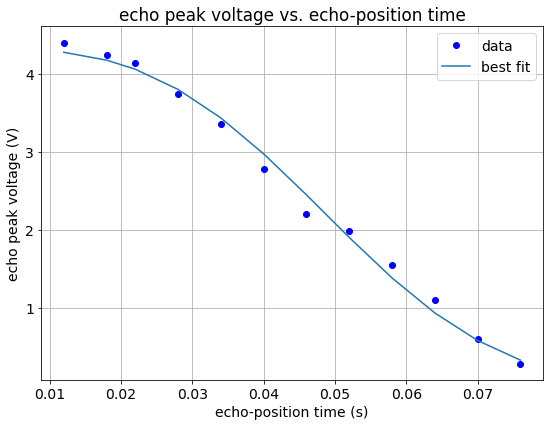

In [23]:
#show and plot the results

print(result.fit_report())

plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('echo peak voltage vs. echo-position time')
plt.ylabel(r'echo peak voltage (V)')
plt.xlabel(r'echo-position time (s)')
plt.plot(echo_position,echo_amp,'ob',label = 'data')
plt.plot(echo_position, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

### Optional: Estimate the self-diffusion constant of water

According to equation (16) in the instructions, 

$$ K = \frac{\gamma^2}{12}\left(\frac{\partial B_0}{\partial z}\right)^2 D$$

and $\gamma\Delta B_0 = \Delta\omega_0$, the spread of precession frequencies that determines $T_2^*$.  From this information and the width of the simple free induction decay, you can use the result for $K$ to estimate $D$ the diffusion constant for water (at room temperature).

Try this, and compare your result against Hahn's: [Hahn, E. L., "Spin echoes", Phys. Rev., 80, 580-594 (1950)](http://courses.washington.edu/phys431/restricted/Hahn_PR80.pdf), p. 589.

In [24]:
#import from the result above the constant K:
k = result.params['K'].value
print('the fitted K is {:.04g}'.format(k))

the fitted K is 5817


$\frac{1}{T_2^*} = \frac{1}{T_2} + \gamma B_0$ by equaiton (12), where $T_2$ is measured to be 769.9 ms, which is much larger than ${T_2^*}$, which we measured from the echo-pulse width to be 440 $\mu s$. Therefore, we can write $B_0 = 1/(T_2^* * \gamma)$ so the gradient $\frac{\partial B_0}{\partial z} = \frac{B_0}{d} = \frac{1}{dT_2^* \gamma}$, where $d$ is the diameter of the vial.

In [25]:
#import gyromagnetic ratio
gamma = 2.6752e8

#record the vial diameter and the echo-pulse width
d = 6e-3
t2s = 440e-6

#calculate the magnetic field gradient

gB = 1/(d*t2s*gamma)

#calculate the diffusion constant 
D = 12*k/(gamma**2 * gB**2)


In [28]:
print('the field gradient is {:.05g}'.format(gB))

the field gradient is 0.0014159


In [29]:
print('the constant is {:.05g}'.format(D))

the constant is 4.8653e-07
